In [ ]:
import torchvision.models
import torch
import numpy as np
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #for gradient descent
import matplotlib.pyplot as plt


In [ ]:
import random
import math
import os
import requests

## Dataset Generation

### Data ingestion

In [ ]:
streetview_base_url = 'https://maps.googleapis.com/maps/api/streetview'

def generate_random_location(location, max_distance_km):
    """
    Generates a random location within a specified maximum distance of a given location.

    Parameters:
    - location: A tuple containing the latitude and longitude of the starting location (lat, lon).
    - max_distance_km: The maximum distance from the starting location in kilometers.

    Returns:
    - A tuple containing the latitude and longitude of the randomly generated location.
    """
    earth_radius_km = 6371.0
    lat1, lon1 = map(math.radians, location)

    random_distance_km = random.random() ** 0.5 * max_distance_km # square root for even distribution
    random_bearing = random.random() * 2 * math.pi

    lat2 = math.asin(math.sin(lat1) * math.cos(random_distance_km / earth_radius_km) +
                     math.cos(lat1) * math.sin(random_distance_km / earth_radius_km) * math.cos(random_bearing))
    lon2 = lon1 + math.atan2(math.sin(random_bearing) * math.sin(random_distance_km / earth_radius_km) * math.cos(lat1),
                             math.cos(random_distance_km / earth_radius_km) - math.sin(lat1) * math.sin(lat2))

    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)

    return (lat2, lon2)

def generate_unique_random_location(existing_locations, location, max_distance_km):
    """
    Generates a unique random location within a specified maximum distance of a given location,
    checking against a set of existing locations to avoid duplicates.

    Parameters:
    - existing_locations: A set containing tuples of (latitude, longitude) of already generated locations.
    - location: The starting location as a tuple (latitude, longitude).
    - max_distance_km: The maximum distance from the starting location in kilometers.

    Returns:
    - A tuple containing the latitude and longitude of the uniquely generated location.
    """
    while True:  # Loop indefinitely until a unique location is found
        new_location = generate_random_location(location, max_distance_km)
        if new_location not in existing_locations:
            existing_locations.add(new_location)
            return new_location

def check_if_street_view_exists(location, key):
    """
    Checks for the existence of a Google Street View image at a given location.

    Parameters:
    - location: A tuple containing the latitude and longitude of the location (lat, lon)
    - key: The API key for accessing the Google Street View Static API.

    Returns:
    - bool: True if an image exists, False otherwise.
    """

    url = f'{streetview_base_url}/metadata'

    params = {
        'location': f'{location[0]},{location[1]}',
        'key': key,
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        metadata = response.json()
        return metadata['status'] == 'OK'
    else: # invalid API key, quota exceeded, etc
        return False

def download_street_view_image(key, prefix, location, size=(256, 256), path='data'):
    """
    Downloads a Google Street View image of a given location and saves it to a specified path.

    Parameters:
    - key: The API key for accessing the Google Street View Static API.
    - prefix: A prefix to add to the filename of the image.
    - location: A tuple containing the latitude and longitude of the location (lat, lon).
    - size: A tuple containing the width and height of the image in pixels (width, height).
    - path: The path where the image should be saved.

    Returns:
    - A string containing the filename of the Street View image, or None if an error occurred.
    """

    params = {
        'size': f'{size[0]}x{size[1]}',
        'location': f'{location[0]},{location[1]}',
        'key': key,
        'return_error_code': 'true'
    }

    response = requests.get(streetview_base_url, params=params)
    if response.status_code == 200:

        os.makedirs(path, exist_ok=True)

        filename = f"{prefix}_{location[0]}_{location[1]}.jpg"
        full_path = os.path.join(path, filename)

        with open(full_path, 'wb') as file:
            file.write(response.content)

        return filename
    else:
        # invalid API key, quota exceeded, etc
        return None


This was done locally otherwise it would have taken too long. The zipfiles were uploaded to the google drive

In [ ]:
key = input("Enter your Google Street View API key: ")

city_centers = {
    "barcelona": (41.387016, 2.170047),
    "london": (51.508206, -0.125033),
    "venice": (45.434185, 12.337817),
    "paris": (48.852966, 2.349902),
}

maximum_distance_km = 10
images_per_city = 10000

for city, center in city_centers.items():
    existing_locations = set()
    print(f'starting downloads for {city}')

    for i in range(images_per_city):
        while True:
            unique_location = generate_unique_random_location(existing_locations, center, maximum_distance_km)

            path = os.path.join("data", city)
            prefix = f"{i}_{city}"
            streetview_exists = check_if_street_view_exists(unique_location, key)
            if streetview_exists:
                filename = download_street_view_image(key, prefix, unique_location, path=path)
                if filename:
                    print(f"Downloaded Street View image for {city} to {filename}")
                    break
                else:
                    print(f"Failed to download Street View image: {i}, city: {city}, location: {unique_location}")
            else:
                print(f"No Street View image exists for {unique_location}")

    print(f'finished downloading images for {city}')

KeyboardInterrupt: Interrupted by user

### Modifying dataset

In [ ]:
#todo normalization and cropping. can use datax256 zip for now which is in the drive, datax256_test_sample contains 10 images should be used for testing and avoid exhausting google cloud usage


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Reading data

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#!unzip -u '/content/gdrive/My Drive/APS360 Group Project/datax256.zip' datax256/venice/* -d '/content/gdrive/My Drive/APS360 Group Project/datax256_2/datax256'

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/My Drive/APS360 Group Project/datax256_2/datax256/datax256/venice/5499_venice_45.45877731027633_12.348179495708473.jpg  
  inflating: /content/gdrive/My Drive/APS360 Group Project/datax256_2/datax256/datax256/venice/55_venice_45.418271423174666_12.263472028438159.jpg  
  inflating: /content/gdrive/My Drive/APS360 Group Project/datax256_2/datax256/datax256/venice/550_venice_45.4420363748045_12.337237680430913.jpg  
  inflating: /content/gdrive/My Drive/APS360 Group Project/datax256_2/datax256/datax256/venice/5500_venice_45.44543123717039_12.325372490646783.jpg  
  inflating: /content/gdrive/My Drive/APS360 Group Project/datax256_2/datax256/datax256/venice/5501_venice_45.432586154956084_12.345790979246832.jpg  
  inflating: /content/gdrive/My Drive/APS360 Group Project/datax256_2/datax256/datax256/venice/5502_venice_45.49570454822006_12.25762367518389.jpg  
  inflating: /content/gdrive/My Drive/APS360 Group P

In [ ]:
#!unzip -u '/content/gdrive/My Drive/APS360 Group Project/datax256_n_500.zip' -d '/content/gdrive/My Drive/APS360 Group Project/datax256_n_500'

Archive:  /content/gdrive/My Drive/APS360 Group Project/datax256_n_500.zip
   creating: /content/gdrive/My Drive/APS360 Group Project/datax256_n_500/datax256_n_500/barcelona/
  inflating: /content/gdrive/My Drive/APS360 Group Project/datax256_n_500/datax256_n_500/barcelona/0_barcelona_41.39822920326392_2.1276690629572377.jpg  
  inflating: /content/gdrive/My Drive/APS360 Group Project/datax256_n_500/datax256_n_500/barcelona/1_barcelona_41.4608061292594_2.1230427050480585.jpg  
  inflating: /content/gdrive/My Drive/APS360 Group Project/datax256_n_500/datax256_n_500/barcelona/10_barcelona_41.42985867209125_2.1992746325916803.jpg  
  inflating: /content/gdrive/My Drive/APS360 Group Project/datax256_n_500/datax256_n_500/barcelona/100_barcelona_41.394907593199996_2.187993302452868.jpg  
  inflating: /content/gdrive/My Drive/APS360 Group Project/datax256_n_500/datax256_n_500/barcelona/101_barcelona_41.430655673886974_2.1087987793670795.jpg  
  inflating: /content/gdrive/My Drive/APS360 Group

In [ ]:
use_cuda = torch.cuda.is_available()

import zipfile
import os

# Directory where the dataset will be extracted
dataset_path = '/content/gdrive/My Drive/APS360 Group Project/datax256_test_sample'

transform = transforms.Compose([
    transforms.Resize((227, 227)), #what size were these suppose to be again? 227 by 227
    transforms.ToTensor(),
])
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
indices = np.arange(len(dataset))

train_split = int(np.floor(0.8 * len(indices)))
val_split = int(np.floor(0.1 * len(indices)))
train_idx, val_idx, test_idx = indices[:train_split], indices[train_split:train_split+val_split], indices[train_split+val_split:]

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)
train_size, val_size, test_size

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

In [ ]:
data_dir = '/content/gdrive/My Drive/APS360 Group Project/datax256_2/datax256'

train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'val/')
test_dir = os.path.join(data_dir, 'test/')
splitfolders.ratio(data_dir, output=data_dir, seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 39695 files [23:52, 27.71 files/s]


In [ ]:
transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
len(val_loader)

125

In [ ]:
for img, label in iter(val_loader):
  print(label)
  break

tensor([1, 2, 0, 0, 3, 0, 0, 1, 3, 2, 0, 2, 1, 3, 1, 0, 0, 2, 1, 1, 1, 1, 3, 0,
        0, 1, 2, 0, 0, 0, 2, 2])


## Shared functions

In [ ]:
def get_accuracy1(extract, model, data_loader):
    correct = 0
    total = 0
    for data, labels in data_loader:
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          data = data.cuda()
          labels = labels.cuda()
        #############################################

        output = model(extract(data))

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += data.shape[0]
    return correct / total

## Baseline Model
AlexNet: Extract features (no finetuning AlexNet) -> FC layers -> 4 outputs

In [ ]:
# import alexnet
alexNet = torchvision.models.alexnet(pretrained=True)
ALNC = alexNet.features

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 70.5MB/s]


In [ ]:
class BaselineClassifier(nn.Module):
    def __init__(self):
        super(BaselineClassifier, self).__init__()
        self.fc1 = nn.Linear(9216, 100)
        self.fc2 = nn.Linear(100, 4)

    def forward(self, x):
        x = x.view(-1, 9216) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def get_accuracy1(extract, model, data_loader):
    correct = 0
    total = 0
    for data, labels in data_loader:
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          data = data.cuda()
          labels = labels.cuda()
        #############################################

        output = model(extract(data))

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()

        total += data.shape[0]
    return correct / total

In [ ]:
def training1(extract, model, train_loader, valid_loader, bs=32, num_epoch=5, lr=0.001, graph=False):
    """
    extract: type of model used for feature extraction
    model: type of classifier used on extracted features
    train_loader: DataLoader of training data
    valid_loader: DataLoader of validation data
    bs: batch size
    num_epoch: number of epochs
    lr: learning rate
    graph: boolean, whether a graph is to be produced
    """

    torch.manual_seed(1)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)

    t_losses, iters, t_acc, v_acc, g_iter = [], [], [], [], []

    i = 0

    for epoch in range(num_epoch):
        for data, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              data = data.cuda()
              labels = labels.cuda()
            #############################################

            output = model(extract(data))
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            t_losses.append(float(loss/bs))

            iters.append(i)
            i += 1

        if graph:
            t_acc.append(get_accuracy1(extract, model, train_loader))
            v_acc.append(get_accuracy1(extract, model, valid_loader))
            g_iter.append(epoch)

    if graph:
        plt.title("Training Curve")
        plt.plot(iters, t_losses, label="Train")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()

        plt.title("Training Curve")
        plt.plot(g_iter, t_acc, label="Train")
        plt.plot(g_iter, v_acc, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Training Accuracy")
        plt.legend(loc='best')
        plt.show()

    print("Final Training Accuracy: {}".format(get_accuracy1(extract, model, train_loader)))
    print("Final Validation Accuracy: {}".format(get_accuracy1(extract, model, valid_loader)))

CUDA is available!  Training on GPU ...


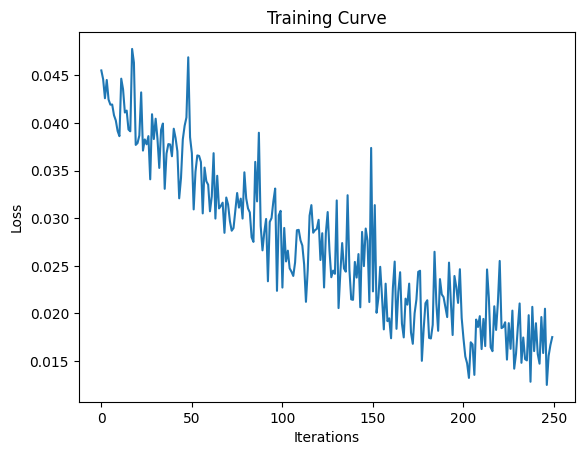

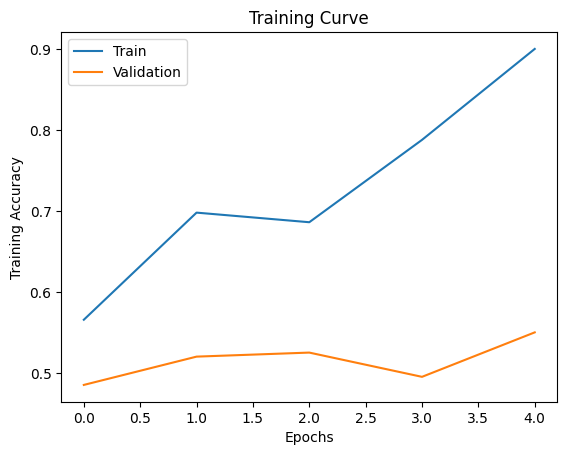

Final Training Accuracy: 0.900625
Final Validation Accuracy: 0.55


In [ ]:
use_cuda = True

model = BaselineClassifier()
ALNC = alexNet.features

if use_cuda and torch.cuda.is_available():
  ALNC.cuda()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

training1(ALNC, model, train_loader, val_loader, bs=32, num_epoch=5, lr=0.001, graph=True)


## Architecture
GoogleNet: Fine-tune last convolution and FC layers -> extract features -> train SVM

In [ ]:
googleNet = torchvision.models.inception_v3(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


In [ ]:
!pip install caffe2pth

ERROR: Could not find a version that satisfies the requirement caffe2pth (from versions: none)
ERROR: No matching distribution found for caffe2pth


In [ ]:
from caffe2pth.caffenet import *

ModuleNotFoundError: No module named 'caffe2pth'

In [ ]:
!python '/content/gdrive/My Drive/APS360 Group Project/caffe2pth_convertor.py' \
 --prototxt='/content/gdrive/MyDrive/APS360 Group Project/deploy_places205.protxt' \
 --caffemodel='/content/gdrive/MyDrive/APS360 Group Project/googlelet_places205_train_iter_2400000.caffemodel' \
 --pthmodel='/content/gdrive/MyDrive/APS360 Group Project'

Traceback (most recent call last):
  File "/content/gdrive/My Drive/APS360 Group Project/caffe2pth_convertor.py", line 14, in <module>
    from caffe2pth.caffenet import *
ModuleNotFoundError: No module named 'caffe2pth'


In [ ]:
import sys
import os

sys.path.insert(0,'/content/gdrive/My Drive/APS360 Group Project/caffe2pth')
import caffenet
from caffenet import *

net = CaffeNet('/content/gdrive/MyDrive/APS360 Group Project/googlelet_places205_train_iter_2400000.caffemodel')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa2 in position 21: invalid start byte

In [ ]:
places205_path = '/content/gdrive/My Drive/APS360 Group Project'

import sys
sys.path.insert(0,places205_path)
# Import your module or file
from googlenet_places205_1 import GoogLeNetPlaces205

placesNet = GoogLeNetPlaces205()
placesNet.load_state_dict(torch.load(places205_path + "/googlenet_places205.pth"), strict=False)
placesNet.eval()

GoogLeNetPlaces205(
  (conv1_7x7_s2): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
  (conv2_3x3_reduce): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv2_3x3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1))
  (inception_3a_1x1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
  (inception_3a_5x5_reduce): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
  (inception_3a_3x3_reduce): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
  (inception_3a_pool_proj): Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1))
  (inception_3a_5x5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (inception_3a_3x3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1))
  (inception_3b_3x3_reduce): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (inception_3b_1x1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (inception_3b_5x5_reduce): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
  (inception_3b_pool_proj): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
  (i

In [ ]:
placesNet.layers

AttributeError: 'GoogLeNetPlaces205' object has no attribute 'layers'

In [ ]:
class auxClassifier(nn.Module):
    def __init__(self):
        super(auxClassifier, self).__init__()
        self.fc1 = nn.Linear(768, 100)
        self.fc2 = nn.Linear(100, 4)

    def forward(self, x):
        x = x.view(-1, 768) # is this necessary?
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class googClassifier(nn.Module):
    def __init__(self):
        super(googClassifier, self).__init__()
        self.fc1 = nn.Linear(2048, 100)
        self.fc2 = nn.Linear(100, 4)

    def forward(self, x):
        x = x.view(-1, 2048) # is this necessary? should it be (-1, 2048)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class placesClassifier(nn.Module):
    def __init__(self):
        super(placesClassifier, self).__init__()
        self.fc1 = nn.Linear(1024, 100)
        self.fc2 = nn.Linear(100, 4)

    def forward(self, x):
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
googleNet.AuxLogits.fc = auxClassifier()
googleNet.fc = googClassifier()
googleNet.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
ignored_params = list(map(id, googleNet.fc.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params,
                     googleNet.parameters())



googleNet.parameters()

<generator object Module.parameters at 0x7981897b7b50>

In [ ]:
class placesMerged(nn.Module):

    def __init__(self, model1, model2):
        super().__init__()

        self.model1 = model1
        self.model2 = model2


    def forward(self, x):
        x1 = self.model1(x)
        x2 = self.model2(x1)

        return x2

In [ ]:
mergedNet = placesMerged(placesNet)

In [ ]:
for layer in mergedNet.features.layers:
    layer.trainable = False

model.features.inception_5a_5x5.parameters()
model.features.inception_5a_3x3.parameters()
model.features.inception_5b_3x3_reduce.parameters()
model.features.inception_5b_5x5_reduce.parameters()
model.features.inception_5b_1x1.parameters()
model.features.inception_5b_pool_proj.parameters()
model.features.inception_5b_3x3.parameters()
model.features.inception_5b_5x5.parameters()

In [ ]:
mergedNet.features.inception_5a_5x5

Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1))

In [ ]:
def get_accuracy2(model, data_loader):
    correct = 0
    total = 0
    for data, labels in data_loader:
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          data = data.cuda()
          labels = labels.cuda()
        #############################################

        output = model(data)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += data.shape[0]
    return correct / total

In [ ]:
def feature_extraction(model, dataloader):
  features = []
  labels = []
  with torch.no_grad():
    for data, label in data_loader:
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        data = data.cuda()
        label = label.cuda()
      #############################################

      output = model(data)

      features.append(output.cpu().numpy())
      labels.append(label.cpu().numpy())

  features = np.concatenate(features, axis=0)
  labels = np.concatenate(labels, axis=0)
  return features, labels

In [ ]:
def training2(model, train_loader, valid_loader, bs=64, num_epoch=5, lr=0.001, graph=False):
    """
    model: type of classifier used on extracted features
    train_loader: DataLoader of training data
    valid_loader: DataLoader of validation data
    bs: batch size
    num_epoch: number of epochs
    lr: learning rate
    graph: boolean, whether a graph is to be produced
    """

    torch.manual_seed(1)
    criterion = nn.CrossEntropyLoss()

    ignored_params = list(map(id, (model.fc.parameters(), model.Mixed_7c.parameters())))
    base_params = filter(lambda p: id(p) in ignored_params,
                     model.parameters())

    '''
    # Alternative method of freezing layers:

    # Freeze fc and mixed_7c layers
    for param in model.fc.parameters():
        param.requires_grad = False
    for param in model.Mixed_7c.parameters():
        param.requires_grad = False

    # Print trainable layers
    for name, param in model.named_parameters():
        print(name, param.requires_grad)

    base_params = filter(lambda p: p.requires_grad, model.parameters())

    '''

    # only fine tune last fully connected layer and inception module
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr, momentum=0.9)

    t_losses, iters, t_acc, v_acc, g_iter = [], [], [], [], []

    i = 0

    for epoch in range(num_epoch):
        for data, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              data = data.cuda()
              labels = labels.cuda()
            #############################################

            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            t_losses.append(float(loss)/bs)

            iters.append(iter)
            i += 1

        if graph:
            t_acc.append(get_accuracy2(model, train_loader))
            v_acc.append(get_accuracy2(model, valid_loader))
            g_iter.append(epoch)

    if graph:
        plt.title("Training Curve")
        plt.plot(iters, t_losses, label="Train")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()

        plt.title("Training Curve")
        plt.plot(g_iter, t_acc, label="Train")
        plt.plot(g_iter, v_acc, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Training Accuracy")
        plt.legend(loc='best')
        plt.show()

    print("Final Training Accuracy: {}".format(get_accuracy2(model, train_loader)))
    print("Final Validation Accuracy: {}".format(get_accuracy2(model, valid_loader)))

In [ ]:
counter = 0
for name, layer in model.named_modules():
    if "Mixed_7c" in name:
        counter = 1
    if counter == 0:
        for param in layer.parameters():
            param.requires_grad = False

Streaming output truncated to the last 5000 lines.
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Parameter containing:
tensor([-1.3936, -0.8007, -0.5469, -0.6668, -0.6238, -0.4083, -0.9899, -1.0097,
        -0.5027, -0.6866, -0.3774, -1.0382, -0.6826, -0.9024, -0.6972, -0.3490,
        -1.1897, -0.4954, -1.2327, -0.8851, -0.5122, -0.9197, -0.4887, -1.1085,
        -0.7469, -0.5629, -0.8240, -0.3428, -0.2606, -0.9006, -0.8120,  0.0315,
        -0.8820, -0.5042, -0.7105, -0.6724, -0.5023, -1.3286, -0.1650,

In [ ]:
use_cuda = True

model = googleNet

counter = 0
for name, layer in model.named_modules():
    if 'Mixed_7c' in name:
        counter = 1
    if counter == 0:
        for param in layer.parameters():
            param.requires_grad = False
    if counter == 1:
        for param in layer.parameters():
            param.requires_grad = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

training2(model, train_loader, val_loader, bs=32, num_epoch=10, lr=0.001, graph=False)

CUDA is available!  Training on GPU ...
Final Training Accuracy: 0.9975
Final Validation Accuracy: 0.455


In [ ]:
rand = torch.randn(1,3,227,227).cuda()
model(rand)

tensor([[-0.0667, -0.0697,  0.1137, -0.1182]], device='cuda:0')

In [ ]:
# For places205 GoogleNet!

def training3(model, train_loader, valid_loader, bs=64, num_epoch=5, lr=0.001, graph=False):
    """
    model: type of classifier used on extracted features
    train_loader: DataLoader of training data
    valid_loader: DataLoader of validation data
    bs: batch size
    num_epoch: number of epochs
    lr: learning rate
    graph: boolean, whether a graph is to be produced
    """

    torch.manual_seed(1)
    criterion = nn.CrossEntropyLoss()

    '''
    ignored_params = list(map(id, (model.fc1.parameters(), model.fc2.parameters(),
                                   model.features.inception_5a_5x5.parameters(),
                                   model.features.inception_5a_3x3.parameters(),
                                   model.features.inception_5b_3x3_reduce.parameters(),
                                   model.features.inception_5b_5x5_reduce.parameters(),
                                   model.features.inception_5b_1x1.parameters(),
                                   model.features.inception_5b_pool_proj.parameters(),
                                   model.features.inception_5b_3x3.parameters(),
                                   model.features.inception_5b_5x5.parameters())))
    base_params = filter(lambda p: id(p) in ignored_params,
                     model.parameters())
    '''
    '''
    # Alternative method of freezing layers:

    # Freeze fc and mixed_7c layers
    for param in model.fc.parameters():
        param.requires_grad = False
    for param in model.Mixed_7c.parameters():
        param.requires_grad = False

    # Print trainable layers
    for name, param in model.named_parameters():
        print(name, param.requires_grad)

    base_params = filter(lambda p: p.requires_grad, model.parameters())

    '''

    # only fine tune last fully connected layer and inception module
    optimizer = torch.optim.SGD(model.model1.parameters(), lr, momentum=0.9)

    t_losses, iters, t_acc, v_acc, g_iter = [], [], [], [], []

    i = 0

    for epoch in range(num_epoch):
        for data, labels in iter(train_loader):
            print(1)
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              data = data.cuda()
              labels = labels.cuda()
            #############################################

            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            t_losses.append(float(loss)/bs)

            iters.append(i)
            i += 1

        if graph:
            t_acc.append(get_accuracy2(model, train_loader))
            v_acc.append(get_accuracy2(model, valid_loader))
            g_iter.append(epoch)

    if graph:
        plt.title("Training Curve")
        plt.plot(iters, t_losses, label="Train")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()

        plt.title("Training Curve")
        plt.plot(g_iter, t_acc, label="Train")
        plt.plot(g_iter, v_acc, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Training Accuracy")
        plt.legend(loc='best')
        plt.show()
    print(3)
    print("Final Training Accuracy: {}".format(get_accuracy2(model, train_loader)))
    print("Final Validation Accuracy: {}".format(get_accuracy2(model, valid_loader)))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GoogLeNetPlaces205(nn.Module):

    def __init__(self):
        super(GoogLeNetPlaces205, self).__init__()
        self.conv1_7x7_s2 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7, 7), stride=(2, 2), groups=1, bias=True)
        self.conv2_3x3_reduce = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.conv2_3x3 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.inception_3a_1x1 = nn.Conv2d(in_channels=192, out_channels=64, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_3a_5x5_reduce = nn.Conv2d(in_channels=192, out_channels=16, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_3a_3x3_reduce = nn.Conv2d(in_channels=192, out_channels=96, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_3a_pool_proj = nn.Conv2d(in_channels=192, out_channels=32, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_3a_5x5 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), stride=(1, 1), groups=1, bias=True)
        self.inception_3a_3x3 = nn.Conv2d(in_channels=96, out_channels=128, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.inception_3b_3x3_reduce = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_3b_1x1 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_3b_5x5_reduce = nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_3b_pool_proj = nn.Conv2d(in_channels=256, out_channels=64, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_3b_3x3 = nn.Conv2d(in_channels=128, out_channels=192, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.inception_3b_5x5 = nn.Conv2d(in_channels=32, out_channels=96, kernel_size=(5, 5), stride=(1, 1), groups=1, bias=True)
        self.inception_4a_1x1 = nn.Conv2d(in_channels=480, out_channels=192, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_4a_3x3_reduce = nn.Conv2d(in_channels=480, out_channels=96, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_4a_5x5_reduce = nn.Conv2d(in_channels=480, out_channels=16, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_4a_pool_proj = nn.Conv2d(in_channels=480, out_channels=64, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_4a_3x3 = nn.Conv2d(in_channels=96, out_channels=208, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.inception_4a_5x5 = nn.Conv2d(in_channels=16, out_channels=48, kernel_size=(5, 5), stride=(1, 1), groups=1, bias=True)
        self.inception_4b_5x5_reduce = nn.Conv2d(in_channels=512, out_channels=24, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_4b_1x1 = nn.Conv2d(in_channels=512, out_channels=160, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_4b_3x3_reduce = nn.Conv2d(in_channels=512, out_channels=112, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_4b_pool_proj = nn.Conv2d(in_channels=512, out_channels=64, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.loss1_conv = nn.Conv2d(in_channels=512, out_channels=128, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_4b_5x5 = nn.Conv2d(in_channels=24, out_channels=64, kernel_size=(5, 5), stride=(1, 1), groups=1, bias=True)
        self.inception_4b_3x3 = nn.Conv2d(in_channels=112, out_channels=224, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.loss1_fc_1 = nn.Linear(in_features = 2048, out_features = 1024, bias = True)
        self.inception_4c_5x5_reduce = nn.Conv2d(in_channels=512, out_channels=24, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_4c_1x1 = nn.Conv2d(in_channels=512, out_channels=128, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_4c_3x3_reduce = nn.Conv2d(in_channels=512, out_channels=128, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_4c_pool_proj = nn.Conv2d(in_channels=512, out_channels=64, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_4c_5x5 = nn.Conv2d(in_channels=24, out_channels=64, kernel_size=(5, 5), stride=(1, 1), groups=1, bias=True)
        self.inception_4c_3x3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.loss1_classifier_1 = nn.Linear(in_features = 1024, out_features = 205, bias = True)
        self.inception_4d_3x3_reduce = nn.Conv2d(in_channels=512, out_channels=144, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_4d_1x1 = nn.Conv2d(in_channels=512, out_channels=112, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_4d_5x5_reduce = nn.Conv2d(in_channels=512, out_channels=32, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_4d_pool_proj = nn.Conv2d(in_channels=512, out_channels=64, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_4d_3x3 = nn.Conv2d(in_channels=144, out_channels=288, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.inception_4d_5x5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), stride=(1, 1), groups=1, bias=True)
        self.inception_4e_1x1 = nn.Conv2d(in_channels=528, out_channels=256, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_4e_5x5_reduce = nn.Conv2d(in_channels=528, out_channels=32, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_4e_3x3_reduce = nn.Conv2d(in_channels=528, out_channels=160, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.loss2_conv = nn.Conv2d(in_channels=528, out_channels=128, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_4e_pool_proj = nn.Conv2d(in_channels=528, out_channels=128, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_4e_5x5 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(5, 5), stride=(1, 1), groups=1, bias=True)
        self.inception_4e_3x3 = nn.Conv2d(in_channels=160, out_channels=320, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.loss2_fc_1 = nn.Linear(in_features = 2048, out_features = 1024, bias = True)
        self.inception_5a_1x1 = nn.Conv2d(in_channels=832, out_channels=256, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_5a_5x5_reduce = nn.Conv2d(in_channels=832, out_channels=32, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_5a_3x3_reduce = nn.Conv2d(in_channels=832, out_channels=160, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_5a_pool_proj = nn.Conv2d(in_channels=832, out_channels=128, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.loss2_classifier_1 = nn.Linear(in_features = 1024, out_features = 205, bias = True)
        self.inception_5a_5x5 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(5, 5), stride=(1, 1), groups=1, bias=True)
        self.inception_5a_3x3 = nn.Conv2d(in_channels=160, out_channels=320, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.inception_5b_3x3_reduce = nn.Conv2d(in_channels=832, out_channels=192, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_5b_5x5_reduce = nn.Conv2d(in_channels=832, out_channels=48, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_5b_1x1 = nn.Conv2d(in_channels=832, out_channels=384, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_5b_pool_proj = nn.Conv2d(in_channels=832, out_channels=128, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.inception_5b_3x3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.inception_5b_5x5 = nn.Conv2d(in_channels=48, out_channels=128, kernel_size=(5, 5), stride=(1, 1), groups=1, bias=True)

    def forward(self, x):
        conv1_7x7_s2_pad = F.pad(x, (3, 3, 3, 3))
        conv1_7x7_s2    = self.conv1_7x7_s2(conv1_7x7_s2_pad)
        conv1_relu_7x7  = F.relu(conv1_7x7_s2)
        pool1_3x3_s2_pad = F.pad(conv1_relu_7x7, (0, 1, 0, 1), value=float('-inf'))
        pool1_3x3_s2    = F.max_pool2d(pool1_3x3_s2_pad, kernel_size=(3, 3), stride=(2, 2), padding=0, ceil_mode=False)
        pool1_norm1     = F.local_response_norm(pool1_3x3_s2, size=5, alpha=9.999999747378752e-05, beta=0.75, k=1.0)
        conv2_3x3_reduce = self.conv2_3x3_reduce(pool1_norm1)
        conv2_relu_3x3_reduce = F.relu(conv2_3x3_reduce)
        conv2_3x3_pad   = F.pad(conv2_relu_3x3_reduce, (1, 1, 1, 1))
        conv2_3x3       = self.conv2_3x3(conv2_3x3_pad)
        conv2_relu_3x3  = F.relu(conv2_3x3)
        conv2_norm2     = F.local_response_norm(conv2_relu_3x3, size=5, alpha=9.999999747378752e-05, beta=0.75, k=1.0)
        pool2_3x3_s2_pad = F.pad(conv2_norm2, (0, 1, 0, 1), value=float('-inf'))
        pool2_3x3_s2    = F.max_pool2d(pool2_3x3_s2_pad, kernel_size=(3, 3), stride=(2, 2), padding=0, ceil_mode=False)
        inception_3a_pool_pad = F.pad(pool2_3x3_s2, (1, 1, 1, 1), value=float('-inf'))
        inception_3a_pool = F.max_pool2d(inception_3a_pool_pad, kernel_size=(3, 3), stride=(1, 1), padding=0, ceil_mode=False)
        inception_3a_1x1 = self.inception_3a_1x1(pool2_3x3_s2)
        inception_3a_5x5_reduce = self.inception_3a_5x5_reduce(pool2_3x3_s2)
        inception_3a_3x3_reduce = self.inception_3a_3x3_reduce(pool2_3x3_s2)
        inception_3a_pool_proj = self.inception_3a_pool_proj(inception_3a_pool)
        inception_3a_relu_1x1 = F.relu(inception_3a_1x1)
        inception_3a_relu_5x5_reduce = F.relu(inception_3a_5x5_reduce)
        inception_3a_relu_3x3_reduce = F.relu(inception_3a_3x3_reduce)
        inception_3a_relu_pool_proj = F.relu(inception_3a_pool_proj)
        inception_3a_5x5_pad = F.pad(inception_3a_relu_5x5_reduce, (2, 2, 2, 2))
        inception_3a_5x5 = self.inception_3a_5x5(inception_3a_5x5_pad)
        inception_3a_3x3_pad = F.pad(inception_3a_relu_3x3_reduce, (1, 1, 1, 1))
        inception_3a_3x3 = self.inception_3a_3x3(inception_3a_3x3_pad)
        inception_3a_relu_5x5 = F.relu(inception_3a_5x5)
        inception_3a_relu_3x3 = F.relu(inception_3a_3x3)
        inception_3a_output = torch.cat((inception_3a_relu_1x1, inception_3a_relu_3x3, inception_3a_relu_5x5, inception_3a_relu_pool_proj), 1)
        inception_3b_3x3_reduce = self.inception_3b_3x3_reduce(inception_3a_output)
        inception_3b_pool_pad = F.pad(inception_3a_output, (1, 1, 1, 1), value=float('-inf'))
        inception_3b_pool = F.max_pool2d(inception_3b_pool_pad, kernel_size=(3, 3), stride=(1, 1), padding=0, ceil_mode=False)
        inception_3b_1x1 = self.inception_3b_1x1(inception_3a_output)
        inception_3b_5x5_reduce = self.inception_3b_5x5_reduce(inception_3a_output)
        inception_3b_relu_3x3_reduce = F.relu(inception_3b_3x3_reduce)
        inception_3b_pool_proj = self.inception_3b_pool_proj(inception_3b_pool)
        inception_3b_relu_1x1 = F.relu(inception_3b_1x1)
        inception_3b_relu_5x5_reduce = F.relu(inception_3b_5x5_reduce)
        inception_3b_3x3_pad = F.pad(inception_3b_relu_3x3_reduce, (1, 1, 1, 1))
        inception_3b_3x3 = self.inception_3b_3x3(inception_3b_3x3_pad)
        inception_3b_relu_pool_proj = F.relu(inception_3b_pool_proj)
        inception_3b_5x5_pad = F.pad(inception_3b_relu_5x5_reduce, (2, 2, 2, 2))
        inception_3b_5x5 = self.inception_3b_5x5(inception_3b_5x5_pad)
        inception_3b_relu_3x3 = F.relu(inception_3b_3x3)
        inception_3b_relu_5x5 = F.relu(inception_3b_5x5)
        inception_3b_output = torch.cat((inception_3b_relu_1x1, inception_3b_relu_3x3, inception_3b_relu_5x5, inception_3b_relu_pool_proj), 1)
        pool3_3x3_s2_pad = F.pad(inception_3b_output, (0, 1, 0, 1), value=float('-inf'))
        pool3_3x3_s2    = F.max_pool2d(pool3_3x3_s2_pad, kernel_size=(3, 3), stride=(2, 2), padding=0, ceil_mode=False)
        inception_4a_1x1 = self.inception_4a_1x1(pool3_3x3_s2)
        inception_4a_3x3_reduce = self.inception_4a_3x3_reduce(pool3_3x3_s2)
        inception_4a_5x5_reduce = self.inception_4a_5x5_reduce(pool3_3x3_s2)
        inception_4a_pool_pad = F.pad(pool3_3x3_s2, (1, 1, 1, 1), value=float('-inf'))
        inception_4a_pool = F.max_pool2d(inception_4a_pool_pad, kernel_size=(3, 3), stride=(1, 1), padding=0, ceil_mode=False)
        inception_4a_relu_1x1 = F.relu(inception_4a_1x1)
        inception_4a_relu_3x3_reduce = F.relu(inception_4a_3x3_reduce)
        inception_4a_relu_5x5_reduce = F.relu(inception_4a_5x5_reduce)
        inception_4a_pool_proj = self.inception_4a_pool_proj(inception_4a_pool)
        inception_4a_3x3_pad = F.pad(inception_4a_relu_3x3_reduce, (1, 1, 1, 1))
        inception_4a_3x3 = self.inception_4a_3x3(inception_4a_3x3_pad)
        inception_4a_5x5_pad = F.pad(inception_4a_relu_5x5_reduce, (2, 2, 2, 2))
        inception_4a_5x5 = self.inception_4a_5x5(inception_4a_5x5_pad)
        inception_4a_relu_pool_proj = F.relu(inception_4a_pool_proj)
        inception_4a_relu_3x3 = F.relu(inception_4a_3x3)
        inception_4a_relu_5x5 = F.relu(inception_4a_5x5)
        inception_4a_output = torch.cat((inception_4a_relu_1x1, inception_4a_relu_3x3, inception_4a_relu_5x5, inception_4a_relu_pool_proj), 1)
        inception_4b_pool_pad = F.pad(inception_4a_output, (1, 1, 1, 1), value=float('-inf'))
        inception_4b_pool = F.max_pool2d(inception_4b_pool_pad, kernel_size=(3, 3), stride=(1, 1), padding=0, ceil_mode=False)
        #loss1_ave_pool  = F.avg_pool2d(inception_4a_output, kernel_size=(5, 5), stride=(3, 3), padding=(0,), ceil_mode=True, count_include_pad=False)
        inception_4b_5x5_reduce = self.inception_4b_5x5_reduce(inception_4a_output)
        inception_4b_1x1 = self.inception_4b_1x1(inception_4a_output)
        inception_4b_3x3_reduce = self.inception_4b_3x3_reduce(inception_4a_output)
        inception_4b_pool_proj = self.inception_4b_pool_proj(inception_4b_pool)
        #loss1_conv      = self.loss1_conv(loss1_ave_pool)
        inception_4b_relu_5x5_reduce = F.relu(inception_4b_5x5_reduce)
        inception_4b_relu_1x1 = F.relu(inception_4b_1x1)
        inception_4b_relu_3x3_reduce = F.relu(inception_4b_3x3_reduce)
        inception_4b_relu_pool_proj = F.relu(inception_4b_pool_proj)
        #loss1_relu_conv = F.relu(loss1_conv)
        inception_4b_5x5_pad = F.pad(inception_4b_relu_5x5_reduce, (2, 2, 2, 2))
        inception_4b_5x5 = self.inception_4b_5x5(inception_4b_5x5_pad)
        inception_4b_3x3_pad = F.pad(inception_4b_relu_3x3_reduce, (1, 1, 1, 1))
        inception_4b_3x3 = self.inception_4b_3x3(inception_4b_3x3_pad)
        #loss1_fc_0      = loss1_relu_conv.view(loss1_relu_conv.size(0), -1)
        inception_4b_relu_5x5 = F.relu(inception_4b_5x5)
        inception_4b_relu_3x3 = F.relu(inception_4b_3x3)
        #loss1_fc_1      = self.loss1_fc_1(loss1_fc_0)
        inception_4b_output = torch.cat((inception_4b_relu_1x1, inception_4b_relu_3x3, inception_4b_relu_5x5, inception_4b_relu_pool_proj), 1)
        #loss1_relu_fc   = F.relu(loss1_fc_1)
        inception_4c_5x5_reduce = self.inception_4c_5x5_reduce(inception_4b_output)
        inception_4c_pool_pad = F.pad(inception_4b_output, (1, 1, 1, 1), value=float('-inf'))
        inception_4c_pool = F.max_pool2d(inception_4c_pool_pad, kernel_size=(3, 3), stride=(1, 1), padding=0, ceil_mode=False)
        inception_4c_1x1 = self.inception_4c_1x1(inception_4b_output)
        inception_4c_3x3_reduce = self.inception_4c_3x3_reduce(inception_4b_output)
        #loss1_drop_fc   = F.dropout(input = loss1_relu_fc, p = 0.699999988079071, training = self.training, inplace = True)
        inception_4c_relu_5x5_reduce = F.relu(inception_4c_5x5_reduce)
        inception_4c_pool_proj = self.inception_4c_pool_proj(inception_4c_pool)
        inception_4c_relu_1x1 = F.relu(inception_4c_1x1)
        inception_4c_relu_3x3_reduce = F.relu(inception_4c_3x3_reduce)
        #loss1_classifier_0 = loss1_drop_fc.view(loss1_drop_fc.size(0), -1)
        inception_4c_5x5_pad = F.pad(inception_4c_relu_5x5_reduce, (2, 2, 2, 2))
        inception_4c_5x5 = self.inception_4c_5x5(inception_4c_5x5_pad)
        inception_4c_relu_pool_proj = F.relu(inception_4c_pool_proj)
        inception_4c_3x3_pad = F.pad(inception_4c_relu_3x3_reduce, (1, 1, 1, 1))
        inception_4c_3x3 = self.inception_4c_3x3(inception_4c_3x3_pad)
        #loss1_classifier_1 = self.loss1_classifier_1(loss1_classifier_0)
        inception_4c_relu_5x5 = F.relu(inception_4c_5x5)
        inception_4c_relu_3x3 = F.relu(inception_4c_3x3)
        inception_4c_output = torch.cat((inception_4c_relu_1x1, inception_4c_relu_3x3, inception_4c_relu_5x5, inception_4c_relu_pool_proj), 1)
        inception_4d_pool_pad = F.pad(inception_4c_output, (1, 1, 1, 1), value=float('-inf'))
        inception_4d_pool = F.max_pool2d(inception_4d_pool_pad, kernel_size=(3, 3), stride=(1, 1), padding=0, ceil_mode=False)
        inception_4d_3x3_reduce = self.inception_4d_3x3_reduce(inception_4c_output)
        inception_4d_1x1 = self.inception_4d_1x1(inception_4c_output)
        inception_4d_5x5_reduce = self.inception_4d_5x5_reduce(inception_4c_output)
        inception_4d_pool_proj = self.inception_4d_pool_proj(inception_4d_pool)
        inception_4d_relu_3x3_reduce = F.relu(inception_4d_3x3_reduce)
        inception_4d_relu_1x1 = F.relu(inception_4d_1x1)
        inception_4d_relu_5x5_reduce = F.relu(inception_4d_5x5_reduce)
        inception_4d_relu_pool_proj = F.relu(inception_4d_pool_proj)
        inception_4d_3x3_pad = F.pad(inception_4d_relu_3x3_reduce, (1, 1, 1, 1))
        inception_4d_3x3 = self.inception_4d_3x3(inception_4d_3x3_pad)
        inception_4d_5x5_pad = F.pad(inception_4d_relu_5x5_reduce, (2, 2, 2, 2))
        inception_4d_5x5 = self.inception_4d_5x5(inception_4d_5x5_pad)
        inception_4d_relu_3x3 = F.relu(inception_4d_3x3)
        inception_4d_relu_5x5 = F.relu(inception_4d_5x5)
        inception_4d_output = torch.cat((inception_4d_relu_1x1, inception_4d_relu_3x3, inception_4d_relu_5x5, inception_4d_relu_pool_proj), 1)
        inception_4e_1x1 = self.inception_4e_1x1(inception_4d_output)
        inception_4e_5x5_reduce = self.inception_4e_5x5_reduce(inception_4d_output)
        #loss2_ave_pool  = F.avg_pool2d(inception_4d_output, kernel_size=(5, 5), stride=(3, 3), padding=(0,), ceil_mode=True, count_include_pad=False)
        inception_4e_3x3_reduce = self.inception_4e_3x3_reduce(inception_4d_output)
        inception_4e_pool_pad = F.pad(inception_4d_output, (1, 1, 1, 1), value=float('-inf'))
        inception_4e_pool = F.max_pool2d(inception_4e_pool_pad, kernel_size=(3, 3), stride=(1, 1), padding=0, ceil_mode=False)
        inception_4e_relu_1x1 = F.relu(inception_4e_1x1)
        inception_4e_relu_5x5_reduce = F.relu(inception_4e_5x5_reduce)
        #loss2_conv      = self.loss2_conv(loss2_ave_pool)
        inception_4e_relu_3x3_reduce = F.relu(inception_4e_3x3_reduce)
        inception_4e_pool_proj = self.inception_4e_pool_proj(inception_4e_pool)
        inception_4e_5x5_pad = F.pad(inception_4e_relu_5x5_reduce, (2, 2, 2, 2))
        inception_4e_5x5 = self.inception_4e_5x5(inception_4e_5x5_pad)
        #loss2_relu_conv = F.relu(loss2_conv)
        inception_4e_3x3_pad = F.pad(inception_4e_relu_3x3_reduce, (1, 1, 1, 1))
        inception_4e_3x3 = self.inception_4e_3x3(inception_4e_3x3_pad)
        inception_4e_relu_pool_proj = F.relu(inception_4e_pool_proj)
        inception_4e_relu_5x5 = F.relu(inception_4e_5x5)
        #loss2_fc_0      = loss2_relu_conv.view(loss2_relu_conv.size(0), -1)
        inception_4e_relu_3x3 = F.relu(inception_4e_3x3)
        #loss2_fc_1      = self.loss2_fc_1(loss2_fc_0)
        inception_4e_output = torch.cat((inception_4e_relu_1x1, inception_4e_relu_3x3, inception_4e_relu_5x5, inception_4e_relu_pool_proj), 1)
        #loss2_relu_fc   = F.relu(loss2_fc_1)
        pool4_3x3_s2_pad = F.pad(inception_4e_output, (0, 1, 0, 1), value=float('-inf'))
        pool4_3x3_s2    = F.max_pool2d(pool4_3x3_s2_pad, kernel_size=(3, 3), stride=(2, 2), padding=0, ceil_mode=False)
        #loss2_drop_fc   = F.dropout(input = loss2_relu_fc, p = 0.699999988079071, training = self.training, inplace = True)
        inception_5a_1x1 = self.inception_5a_1x1(pool4_3x3_s2)
        inception_5a_5x5_reduce = self.inception_5a_5x5_reduce(pool4_3x3_s2)
        inception_5a_pool_pad = F.pad(pool4_3x3_s2, (1, 1, 1, 1), value=float('-inf'))
        inception_5a_pool = F.max_pool2d(inception_5a_pool_pad, kernel_size=(3, 3), stride=(1, 1), padding=0, ceil_mode=False)
        inception_5a_3x3_reduce = self.inception_5a_3x3_reduce(pool4_3x3_s2)
        #loss2_classifier_0 = loss2_drop_fc.view(loss2_drop_fc.size(0), -1)
        inception_5a_relu_1x1 = F.relu(inception_5a_1x1)
        inception_5a_relu_5x5_reduce = F.relu(inception_5a_5x5_reduce)
        inception_5a_pool_proj = self.inception_5a_pool_proj(inception_5a_pool)
        inception_5a_relu_3x3_reduce = F.relu(inception_5a_3x3_reduce)
        #loss2_classifier_1 = self.loss2_classifier_1(loss2_classifier_0)
        inception_5a_5x5_pad = F.pad(inception_5a_relu_5x5_reduce, (2, 2, 2, 2))
        inception_5a_5x5 = self.inception_5a_5x5(inception_5a_5x5_pad)
        inception_5a_relu_pool_proj = F.relu(inception_5a_pool_proj)
        inception_5a_3x3_pad = F.pad(inception_5a_relu_3x3_reduce, (1, 1, 1, 1))
        inception_5a_3x3 = self.inception_5a_3x3(inception_5a_3x3_pad)
        inception_5a_relu_5x5 = F.relu(inception_5a_5x5)
        inception_5a_relu_3x3 = F.relu(inception_5a_3x3)
        inception_5a_output = torch.cat((inception_5a_relu_1x1, inception_5a_relu_3x3, inception_5a_relu_5x5, inception_5a_relu_pool_proj), 1)
        inception_5b_3x3_reduce = self.inception_5b_3x3_reduce(inception_5a_output)
        inception_5b_pool_pad = F.pad(inception_5a_output, (1, 1, 1, 1), value=float('-inf'))
        inception_5b_pool = F.max_pool2d(inception_5b_pool_pad, kernel_size=(3, 3), stride=(1, 1), padding=0, ceil_mode=False)
        inception_5b_5x5_reduce = self.inception_5b_5x5_reduce(inception_5a_output)
        inception_5b_1x1 = self.inception_5b_1x1(inception_5a_output)
        inception_5b_relu_3x3_reduce = F.relu(inception_5b_3x3_reduce)
        inception_5b_pool_proj = self.inception_5b_pool_proj(inception_5b_pool)
        inception_5b_relu_5x5_reduce = F.relu(inception_5b_5x5_reduce)
        inception_5b_relu_1x1 = F.relu(inception_5b_1x1)
        inception_5b_3x3_pad = F.pad(inception_5b_relu_3x3_reduce, (1, 1, 1, 1))
        inception_5b_3x3 = self.inception_5b_3x3(inception_5b_3x3_pad)
        inception_5b_relu_pool_proj = F.relu(inception_5b_pool_proj)
        inception_5b_5x5_pad = F.pad(inception_5b_relu_5x5_reduce, (2, 2, 2, 2))
        inception_5b_5x5 = self.inception_5b_5x5(inception_5b_5x5_pad)
        inception_5b_relu_3x3 = F.relu(inception_5b_3x3)
        inception_5b_relu_5x5 = F.relu(inception_5b_5x5)
        inception_5b_output = torch.cat((inception_5b_relu_1x1, inception_5b_relu_3x3, inception_5b_relu_5x5, inception_5b_relu_pool_proj), 1)
        pool5_7x7_s1    = F.avg_pool2d(inception_5b_output, kernel_size=(7, 7), stride=(1, 1), padding=(0,), ceil_mode=False, count_include_pad=False)
        pool5_drop_7x7_s1 = F.dropout(input = pool5_7x7_s1, p = 0.4000000059604645, training = self.training, inplace = True)
        return pool5_drop_7x7_s1
        #return pool5_drop_7x7_s1#, loss2_classifier_1, loss1_classifier_1
        # The Aux classifiers were causing errors with classification, so I commented them out in the forward function.



In [ ]:
model1 = GoogLeNetPlaces205()
model1.eval()

GoogLeNetPlaces205(
  (conv1_7x7_s2): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
  (conv2_3x3_reduce): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv2_3x3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1))
  (inception_3a_1x1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
  (inception_3a_5x5_reduce): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
  (inception_3a_3x3_reduce): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
  (inception_3a_pool_proj): Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1))
  (inception_3a_5x5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (inception_3a_3x3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1))
  (inception_3b_3x3_reduce): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (inception_3b_1x1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (inception_3b_5x5_reduce): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
  (inception_3b_pool_proj): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
  (i

In [ ]:
state_dict = torch.load(places205_path + "/googlenet_places205.pth")
state_dict.keys()

odict_keys(['conv1_7x7_s2.weight', 'conv1_7x7_s2.bias', 'conv2_3x3_reduce.weight', 'conv2_3x3_reduce.bias', 'conv2_3x3.weight', 'conv2_3x3.bias', 'inception_3a_1x1.weight', 'inception_3a_1x1.bias', 'inception_3a_5x5_reduce.weight', 'inception_3a_5x5_reduce.bias', 'inception_3a_3x3_reduce.weight', 'inception_3a_3x3_reduce.bias', 'inception_3a_pool_proj.weight', 'inception_3a_pool_proj.bias', 'inception_3a_5x5.weight', 'inception_3a_5x5.bias', 'inception_3a_3x3.weight', 'inception_3a_3x3.bias', 'inception_3b_3x3_reduce.weight', 'inception_3b_3x3_reduce.bias', 'inception_3b_1x1.weight', 'inception_3b_1x1.bias', 'inception_3b_5x5_reduce.weight', 'inception_3b_5x5_reduce.bias', 'inception_3b_pool_proj.weight', 'inception_3b_pool_proj.bias', 'inception_3b_3x3.weight', 'inception_3b_3x3.bias', 'inception_3b_5x5.weight', 'inception_3b_5x5.bias', 'inception_4a_1x1.weight', 'inception_4a_1x1.bias', 'inception_4a_3x3_reduce.weight', 'inception_4a_3x3_reduce.bias', 'inception_4a_5x5_reduce.weight'

In [ ]:
model1 = model1.load_state_dict(torch.load(places205_path + "/googlenet_places205.pth"))
model1.eval()

AttributeError: '_IncompatibleKeys' object has no attribute 'load_state_dict'

In [ ]:
for child in model.model1.children():
    print(child)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1))
Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1))
Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 96, kernel_size=(5, 5), stride=(1, 1))
Conv2d(480, 192, kernel_size=(1, 1), stride=(1, 1))
Conv2d(480, 96, kernel_size=(1, 1), stride=(1, 1))
Conv2d(480, 16, kernel_size=(1, 1), stride=(1, 1))
Conv2d(480, 64, kernel_size=(1, 1), stride=(1, 1))
Conv2d(96, 208, kernel_size=(3, 

In [ ]:
use_cuda = True

model1 = GoogLeNetPlaces205()
model2 = placesClassifier()
model = placesMerged(model1, model2)

for child in model.model1.children():
    for param in child.parameters():
        param.requires_grad = False

loaded_dict = torch.load(places205_path + "/googlenet_places205.pth")
prefix = 'model1.'
adapted_dict = {prefix + k: v for k, v in loaded_dict.items()}
model.load_state_dict(adapted_dict, strict=False)

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

training3(model, train_loader, val_loader, bs=32, num_epoch=1, lr=0.001, graph=False)

CUDA is available!  Training on GPU ...
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
Final Training Accuracy: 0.251875
2
2
2
2
2
2
2
Final Validation Accuracy: 0.255


In [ ]:
use_cuda = True

model = placesClassifier()
ALNC = placesNet

if use_cuda and torch.cuda.is_available():
  model.cuda()
  ALNC.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')


training1(ALNC, model, train_loader, val_loader, bs=32, num_epoch=1, lr=0.001, graph=False)

CUDA is available!  Training on GPU ...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32768x1 and 1024x100)

In [ ]:
next(val_dataset)

TypeError: 'DataLoader' object is not an iterator

In [ ]:
'''

# import SVC classifier
from sklearn.svm import SVC

# import metrics to compute accuracy
from sklearn.metrics import accuracy_score

# instantiate classifier with default hyperparameters
svc=SVC()
features = []
labels = []

# ========================================================== #

# I'm not quite sure how training a SVM works... I don't think this is right



def SVMtrain(model, train_loader, valid_loader, bs=64, num_epoch=5, lr=0.001, graph=False):
    for epoch in range(num_epoch):
        for data, labels in iter(train_loader):
            # fit classifier to training set
            svc.fit(X_train,y_train)
            # make predictions on test set
            y_pred=svc.predict(X_test)



# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

'''

In [ ]:

# Alternate SVM code

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import torch


def prepare_data(loader):
    features = []
    labels = []
    for data, label in loader:
        features.append(data.numpy())
        labels.append(label.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    features = features.reshape(features.shape[0], -1) # flatten if not done before
    return features, labels


def SVMtrain(model, train_loader, valid_loader):
    train_features, train_labels = prepare_data(train_loader)
    valid_features, valid_labels = prepare_data(valid_loader)
    model.fit(train_features, train_labels)
    valid_pred = model.predict(valid_features)
    accuracy = accuracy_score(valid_labels, valid_pred)
    print('Model accuracy score with default hyperparameters: {0:0.4f}'.format(accuracy))

svc = SVC()
SVMtrain(svc, train_loader, valid_loader)

